<a href="https://colab.research.google.com/github/marta-brasola/FinancialMarketAnalytics/blob/prova/financial_09_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
def get_log_returns(data):
  """
  obiettivo è calcolare i returns delle stocks
  """
  prices = data['PX_LAST'].reset_index()
  prices = prices.rename_axis(None, axis=1)
  prices = prices.replace(0, np.NAN)
  prices = prices.fillna(np.nan)
  prices = prices.set_index('Date')
  returns = np.log(prices/prices.shift(1))
  returns = returns.iloc[1::]
  return returns

def calculate_quantile_returns(data_frame, column_name, returns_df, num_quantiles=5):
    """
    Calculate quantile returns based on the specified column in the DataFrame.
    """

    quantile_ranks = pd.DataFrame(index=data_frame.index, columns=data_frame.columns.levels[1])
    ind_rank = data_frame[column_name]
    ind_rank = ind_rank.replace(0, np.nan)

    for date in ind_rank.index:
        row_values = ind_rank.loc[date]
        # come mai c'è questa condizione del count?
        if row_values.count() > 1:
          ranks = pd.Series(row_values).rank(method='max')
          quintiles = pd.qcut(ranks, q=num_quantiles, labels=False)
          quantile_ranks.loc[date] = quintiles

    quantile_dfs = {}
    portfolio_returns = pd.DataFrame()

    for quantile in range(num_quantiles):
        filtered_df = returns_df[quantile_ranks == quantile]
        filtered_df_shifted = filtered_df
        quantile_dfs[quantile] = filtered_df_shifted
        portfolio_returns[quantile] = quantile_dfs[quantile].mean(axis=1).dropna()

    return quantile_dfs, portfolio_returns

# DA CONTROLLARE PRIMA DI CONSEGNARE PER DECIDERE SE TGLIERLI
# TUTTA LA PARTE DEI RITORNI CUMULATIVI

def calculate_cumulative_return(portfolio_returns):
    """
    Calculate the cumulative return of a portfolio.
    """
    return (1 + portfolio_returns).prod() - 1


def calculate_annualized_return(cumulative_return,portfolio_returns, num_periods=12):
    """
    Calculate the annualized return of a portfolio.
    """
    return (1 + cumulative_return) ** (num_periods / len(portfolio_returns)) - 1


def calculate_annual_volatility(portfolio_returns, num_periods=12):
    """
    Calculate the annualized volatility of a portfolio.
    """
    return portfolio_returns.std() * math.sqrt(num_periods)


def calculate_risk_adjusted_return(annualized_return, annual_volatility):
    """
    Calculate the risk-adjusted return (Sharpe ratio) of a portfolio.
    """
    return annualized_return / annual_volatility


def calculate_IR(portfolio_returns, benchmark_returns):
    """
    Calculate the Information Ratio.
    """

    active_return = portfolio_returns-benchmark_returns
    tracking_error = np.std(portfolio_returns-benchmark_returns)


    return active_return.mean() / tracking_error

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/financial/data/Euro_preprocessed.csv', header=[0,1], index_col=[0])

In [ ]:
df = df.replace(0, np.nan)
df.head()

indicators 10_YEAR_MOVING_AVERAGE_PE                                     \
tickers                       02P GR 1BM GR 1PL GR 1VS GR 2HR GR 3W9 GR   
Date                                                                      
2003-01-31                       NaN    NaN    NaN    NaN    NaN    NaN   
2003-02-28                       NaN    NaN    NaN    NaN    NaN    NaN   
2003-03-31                       NaN    NaN    NaN    NaN    NaN    NaN   
2003-04-30                       NaN    NaN    NaN    NaN    NaN    NaN   
2003-05-30                       NaN    NaN    NaN    NaN    NaN    NaN   

indicators                               ... WACC_COST_EQUITY                  \
tickers    5AB GR 9AR GR A3TV SM AAD GR  ...           YRM IM YTY1V FH ZAR GR   
Date                                     ...                                    
2003-01-31    NaN    NaN     NaN    NaN  ...          10.8039   6.3797    NaN   
2003-02-28    NaN    NaN     NaN    NaN  ...          10.8039   6.3797    NaN   
2003-03-31    NaN    NaN     NaN    NaN  ...          10.8039   6.2664    NaN   
2003-04-30    NaN    NaN     NaN    NaN  ...          10.8039   6.2664    NaN   
2003-05-30    NaN    NaN     NaN    NaN  ...          10.8039   6.2664    NaN   

indicators                                                              
tickers       ZC FP   ZEL SM ZIGGO NA ZIL2 GR   ZO1 GR  ZOT SM   ZV IM  
Date                                                                    
2003-01-31   9.3182  12.5229      NaN     NaN  11.1423  6.8462  8.7721  
2003-02-28  11.7907  12.5229      NaN     NaN  11.1423  6.8462  8.7721  
2003-03-31  11.7907  11.3917      NaN  7.9502  11.1423  6.8462  8.7721  
2003-04-30  11.7907  11.3917      NaN  7.9502  11.1423  6.8462  8.7721  
2003-05-30  11.7907  11.3917      NaN  7.9502  11.1423  6.1677  8.7721  

[5 rows x 31920 columns]

## Checking null values

In [ ]:
tot_values = 111*797
null_ind = df.isnull().groupby(level=0, axis=1).sum().sum(axis=0).reset_index()
null_ind.columns = ['indicators', 'null_values']
null_ind['perc_null_values'] = (null_ind['null_values'] / tot_values) * 100
null_ind.sort_values(by='perc_null_values', ascending=False)
ind_drop = list(null_ind[null_ind['perc_null_values']>50]['indicators'])
ind_drop

['10_YEAR_MOVING_AVERAGE_PE',
 'BEST_EPS',
 'EQY_DPS_NET_5YR_GROWTH',
 'T12M_DIL_EPS_CONT_OPS',
 'T12M_DIL_PE_CONT_OPS',
 'T12M_DVD_PAYOUT_RATIO']

In [ ]:
df.drop(columns=ind_drop, inplace=True)
prova = len(df.columns.get_level_values(0).unique())
print(f"number of indicators remaining: {prova}")

number of indicators remaining: 34


In [ ]:
returns = get_log_returns(df)

In [ ]:
print(returns.shape)
returns.head()

(110, 798)


,02P GR,1BM GR,1PL GR,1VS GR,2HR GR,3W9 GR,5AB GR,9AR GR,A3TV SM,AAD GR,...,YRM IM,YTY1V FH,ZAR GR,ZC FP,ZEL SM,ZIGGO NA,ZIL2 GR,ZO1 GR,ZOT SM,ZV IM
Date,,,,,,,,,,,,,,,,,,,,,
2003-02-28,0.287682,-0.541159,NaN,0.154601,0.010380,0.045549,NaN,0.368801,0.221576,-0.200671,...,NaN,-0.023670,-0.040274,-0.108803,0.025081,NaN,-0.024713,NaN,-0.014286,NaN
2003-03-31,0.000000,-0.018727,NaN,0.232112,-0.034946,-0.115929,NaN,0.003222,-0.003714,-0.122796,...,NaN,-0.128106,0.125969,-0.113053,0.078275,NaN,0.028018,NaN,0.011922,NaN
2003-04-30,0.000000,0.000000,NaN,-0.074877,0.026262,-0.012579,-0.086221,0.114510,0.125197,0.077333,...,NaN,0.085286,-0.085695,0.263255,0.135976,NaN,0.292823,-0.065182,0.007880,NaN
2003-05-30,0.040822,0.000000,NaN,0.074877,0.006760,-0.024561,-0.388015,0.055791,-0.099765,-0.047628,...,NaN,0.033193,0.132873,-0.035233,0.101784,NaN,0.074108,-0.097732,0.092805,NaN
2003-06-30,-0.024293,0.119252,NaN,-0.077962,0.067901,-0.084557,-0.176351,0.052842,0.045276,0.275412,...,NaN,0.027432,0.009174,0.084447,-0.276132,NaN,0.305382,-0.004179,0.029580,NaN


In [ ]:
indicators = df.columns.get_level_values(0).unique()

In [ ]:
benchmark_returns = returns.mean(axis=1)

In [ ]:
indicator_IR = pd.DataFrame(index=indicators, columns=['IR_top_quantile', 'IR_bottom_quantile', 'tracking_top_quantile',
                                                       'tracking_error_bottom_quantile', 'returns_top_quantile', 'returns_bottom_quantile'])

for indicator in indicators:
    result_dfs, portfolio_returns = calculate_quantile_returns(df, indicator, returns)
    indicator_IR.at[indicator, 'IR_top_quantile'] = calculate_IR(portfolio_returns[4], benchmark_returns)
    indicator_IR.at[indicator, 'IR_bottom_quantile'] = calculate_IR(portfolio_returns[0], benchmark_returns)
    indicator_IR.at[indicator, 'tracking_top_quantile'] = np.std(portfolio_returns[4]-benchmark_returns)
    indicator_IR.at[indicator, 'tracking_error_bottom_quantile'] = np.std(portfolio_returns[0]-benchmark_returns)
    indicator_IR.at[indicator, 'returns_top_quantile'] = np.mean(portfolio_returns[4]) * 100
    indicator_IR.at[indicator, 'returns_bottom_quantile'] = np.mean(portfolio_returns[0]) * 100


indicator_IR.sort_values('IR_top_quantile', ascending = False)

,IR_top_quantile,IR_bottom_quantile,tracking_top_quantile,tracking_error_bottom_quantile,returns_top_quantile,returns_bottom_quantile
indicators,,,,,,
RSI_9D,2.141123,-2.717937,0.022825,0.01865,5.42634,-4.529742
RSI_14D,1.753973,-1.756464,0.022738,0.022511,4.527477,-3.414823
RSI_30D,1.201953,-0.750993,0.022131,0.026025,3.199239,-1.415219
EQY_REC_CONS,0.953733,-0.838324,0.01255,0.016221,1.736173,-0.820675
PX_TO_TANG_BV_PER_SH,0.740319,-0.713526,0.010313,0.018436,1.302666,-0.776268
PX_TO_BOOK_RATIO,0.722828,-0.762302,0.015423,0.023078,1.654054,-1.220022
PE_RATIO,0.643904,-0.627384,0.014012,0.018692,1.441417,-0.633525
CURRENT_EV_TO_T12M_EBITDA,0.582441,-0.485095,0.015215,0.018816,1.42539,-0.373539
CURRENT_EV_TO_12M_SALES,0.37707,-0.470959,0.015111,0.015268,1.108995,-0.179847


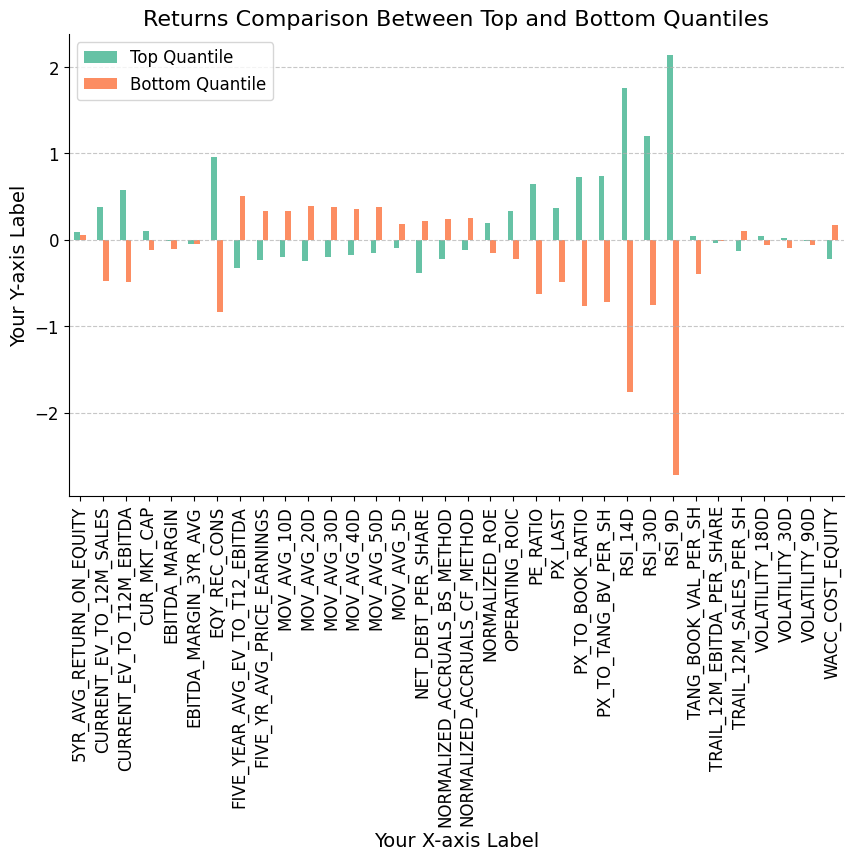

In [ ]:
sns.set_palette('Set2')
# Assuming 'indicator_IR' is your DataFrame
ax = indicator_IR[['IR_top_quantile','IR_bottom_quantile']].plot(kind='bar', figsize=(10, 6))

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Returns Comparison Between Top and Bottom Quantiles', fontsize=16)
plt.xlabel('Your X-axis Label', fontsize=14)
plt.ylabel('Your Y-axis Label', fontsize=14)
plt.legend(['Top Quantile', 'Bottom Quantile'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90, ha='center', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

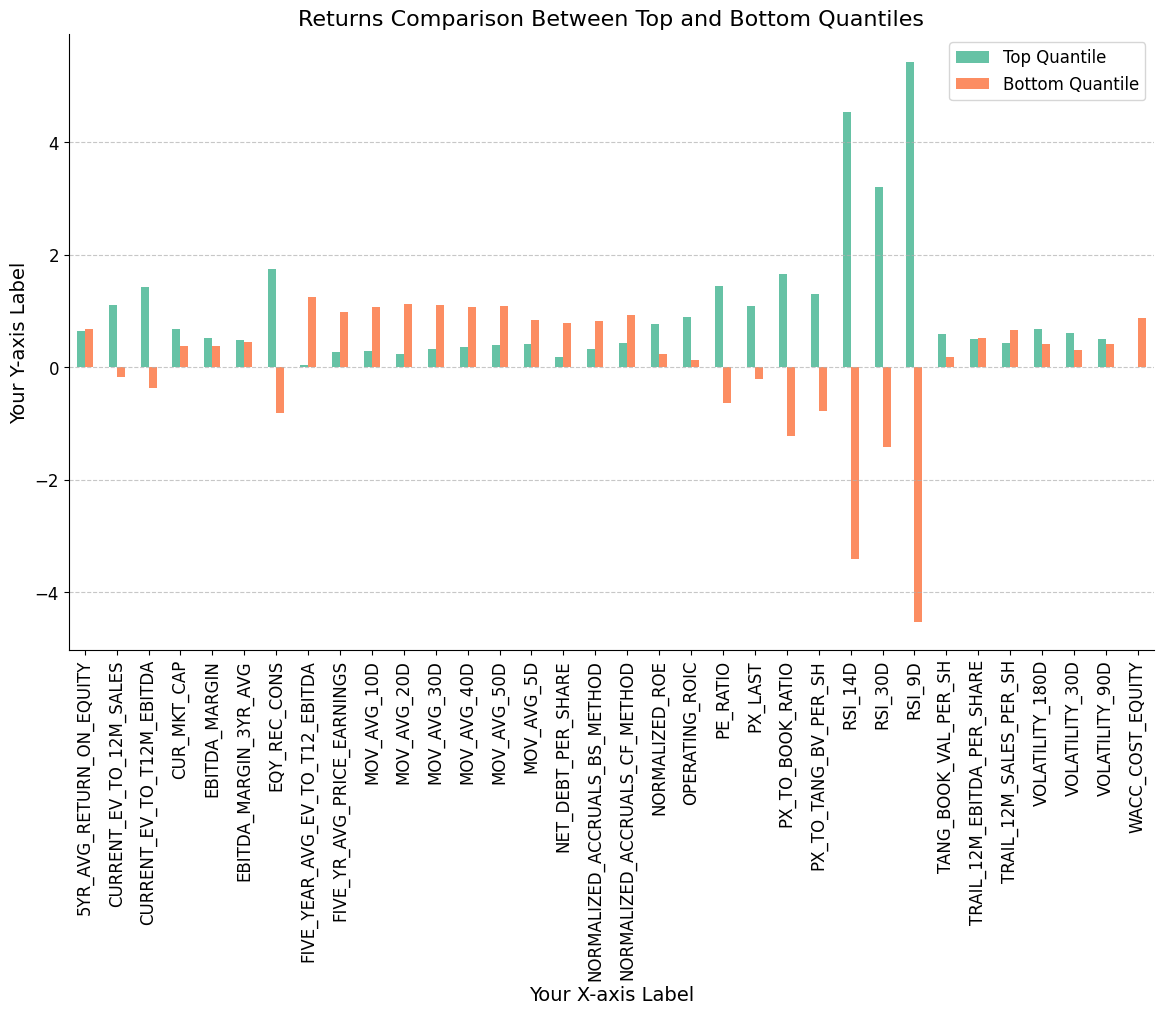

In [ ]:
sns.set_palette('Set2')
# Assuming 'indicator_IR' is your DataFrame
ax = indicator_IR[['returns_top_quantile', 'returns_bottom_quantile']].plot(kind='bar', figsize=(14, 8))

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Returns Comparison Between Top and Bottom Quantiles', fontsize=16)
plt.xlabel('Your X-axis Label', fontsize=14)
plt.ylabel('Your Y-axis Label', fontsize=14)
plt.legend(['Top Quantile', 'Bottom Quantile'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90, ha='center', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Turnover

Da completare
  - selezione del tipo di indicatore in maniera automatica perchè voglio sapere quanto turnover genera ogni indicatore e penalizzare quelli che cambiano azioni nel portafoglio troppo velocemente --> ci sono costi di transazione

In [ ]:
best_stocks2 = pd.DataFrame(index=df.index, columns=indicators)

# Loop through each indicator
for ind in indicators:
    result_dfs, portfolio_returns = calculate_quantile_returns(df, ind, returns)

    # For each date, store the list of best stocks in the corresponding column
    for index, row in result_dfs[4].iterrows():
        best_stocks2.loc[index, ind] = list(row.dropna().index)

In [ ]:
best_stocks2_date = best_stocks2.reset_index()

In [ ]:
turnover_df = pd.DataFrame(index = df.index)

In [ ]:
def turnover_select(indicator, best_stocks2=best_stocks2, best_stocks2_date=best_stocks2_date):

    expanded_df2 = best_stocks2[indicator].explode()
    merged_df = pd.merge(best_stocks2_date[[indicator, 'Date']], expanded_df2, how='right', left_on='Date', right_on='Date')
    changed_stocks = merged_df.groupby('Date')[indicator + '_y'].apply(set).diff().apply(lambda x: list(x) if isinstance(x, set) else []) ## questa non mi è ben chiara come fa quello che fa

    turnover_df[indicator] = changed_stocks.apply(lambda x: len(x))

In [ ]:
for ind in indicators:
    turnover_select(indicator=ind)

In [ ]:
list1 = [item for sublist in best_stocks2['PX_TO_BOOK_RATIO'][2:3].values for item in sublist]
list2 = [item for sublist in best_stocks2['PX_TO_BOOK_RATIO'][3:4].values for item in sublist]

differences = set(list2) - set(list1)

# Print the count of different elements
print(f"Number of different elements: {len(differences)}")

Number of different elements: 13


In [ ]:
stats = round(turnover_df.mean(),2).T.reset_index()
stats.columns = ['index', 'average']
stats.sort_values(by='average', ascending=False)

,index,average
31,VOLATILITY_30D,51.50
26,RSI_9D,34.04
6,EQY_REC_CONS,33.87
24,RSI_14D,27.28
32,VOLATILITY_90D,21.62
25,RSI_30D,17.88
16,NORMALIZED_ACCRUALS_BS_METHOD,16.67
20,PE_RATIO,16.01
2,CURRENT_EV_TO_T12M_EBITDA,13.07
30,VOLATILITY_180D,12.37


## Multivariate strategy  

In [ ]:
def calculate_quantile_returns_zscore(data_frame, column_name, returns_df, num_quantiles=5):
    """
    Calculate quantile returns based on the specified column in the DataFrame.
    """

    quantile_ranks = pd.DataFrame(index=data_frame.index, columns=data_frame.columns)
    ind_rank = data_frame[column_name]
    ind_rank = ind_rank.replace(0, np.nan)

    for date in ind_rank.index:
        row_values = ind_rank.loc[date]
        if row_values.count() > 1:
          ranks = pd.Series(row_values).rank(method='max')
          quintiles = pd.qcut(ranks, q=num_quantiles, labels=False)
          quantile_ranks.loc[date] = quintiles

    quantile_dfs = {}
    portfolio_returns = pd.DataFrame()

    for quantile in range(num_quantiles):
        filtered_df = returns_df[quantile_ranks == quantile]
        filtered_df_shifted = filtered_df
        quantile_dfs[quantile] = filtered_df_shifted
        portfolio_returns[quantile] = quantile_dfs[quantile].mean(axis=1).dropna()

    return quantile_dfs, portfolio_returns

In [ ]:
z_score = (df-df.T.groupby(level=0).mean().T)/df.T.groupby(level=0).std().T

levels = [0.1, 0.25, 0.5, 1, 1.5, 2]
indicator_IR_z = pd.DataFrame(index=levels, columns=['IR_max_quant', 'tracking_error_max', 'returns_max'])

for selection_level in levels:
    sel_z_score = z_score[indicator_IR[(indicator_IR['IR_top_quantile']>selection_level)].index].merge(-z_score[indicator_IR[(indicator_IR['IR_bottom_quantile']>selection_level)].index], on='Date')
    final = sel_z_score.T.groupby(level=1).sum().T

    result_dfs_2, portfolio_returns_2 = calculate_quantile_returns_zscore(final, final.columns, returns)

    indicator_IR_z.at[selection_level, 'IR_max_quant'] = calculate_IR(portfolio_returns_2[4], benchmark_returns)
    indicator_IR_z.at[selection_level, 'tracking_error_max'] = np.std(portfolio_returns_2[4]-benchmark_returns)
    indicator_IR_z.at[selection_level, 'returns_max'] = np.mean(portfolio_returns_2[4]) * 100

indicator_IR_z

,IR_max_quant,tracking_error_max,returns_max
0.10,1.577063,0.02072,3.806905
0.25,1.744382,0.019971,4.022865
0.50,1.742151,0.020798,4.162527
1.00,1.705975,0.022515,4.380173
1.50,1.964897,0.0226,4.97978
2.00,2.141123,0.022825,5.42634


In [ ]:
indicator_IR_z_2 = pd.DataFrame(columns=['IR_max_quant', 'tracking_error_max', 'returns_max'])

pos_factors = [
    "PE_RATIO",
    "CURRENT_EV_TO_T12M_EBITDA",
    "TANG_BOOK_VAL_PER_SH",
    "EBITDA_MARGIN",
    "RSI_9D",
    "5YR_AVG_RETURN_ON_EQUITY",
    "PX_TO_BOOK_RATIO",
    "VOLATILITY_180D"
]

neg_factors = [
    "NET_DEBT_PER_SHARE"
]

sel_z_score = z_score[pos_factors].merge(-z_score[neg_factors], on='Date')
final = sel_z_score.T.groupby(level=1).sum().T

result_dfs_3, portfolio_returns_3 = calculate_quantile_returns_zscore(final, final.columns, returns)

indicator_IR_z_2.at[0, 'IR_max_quant'] = calculate_IR(portfolio_returns_3[4], benchmark_returns)
indicator_IR_z_2.at[0, 'tracking_error_max'] = np.std(portfolio_returns_3[4]-benchmark_returns)
indicator_IR_z_2.at[0, 'returns_max'] = np.mean(portfolio_returns_3[4]) * 100

indicator_IR_z_2

,IR_max_quant,tracking_error_max,returns_max
0,2.214473,0.015053,3.872585


## Machine Learning

In [ ]:
df2 = df.copy(deep=True)
df2.drop(df2.head(1).index, inplace=True)
r = pd.DataFrame(returns.values, index=returns.index,  columns=pd.MultiIndex.from_product([['RETURNS'], returns.columns]))
df2 = pd.concat([df2, r], axis=1)
data_stack = df2.stack()
data_stack

indicators          5YR_AVG_RETURN_ON_EQUITY  CURRENT_EV_TO_12M_SALES  \
Date       tickers                                                      
2003-02-28 02P GR                        NaN                      NaN   
           1BM GR                        NaN                      NaN   
           1PL GR                        NaN                      NaN   
           1VS GR                        NaN                      NaN   
           2HR GR                        NaN                   0.5510   
...                                      ...                      ...   
2012-03-30 ZAR GR                    20.4554                   0.9637   
           ZC FP                     13.8480                   1.8066   
           ZEL SM                   -16.6164                   2.8870   
           ZIL2 GR                   17.5543                   1.5609   
           ZOT SM                    96.5949                   4.2901   

indicators          CURRENT_EV_TO_T12M_EBITDA  CUR_MKT_CAP  EBITDA_MARGIN  \
Date       tickers                                                          
2003-02-28 02P GR                         NaN          NaN            NaN   
           1BM GR                         NaN          NaN            NaN   
           1PL GR                         NaN          NaN        25.0142   
           1VS GR                         NaN    1665.0000            NaN   
           2HR GR                      5.0486     110.6586        10.9136   
...                                       ...          ...            ...   
2012-03-30 ZAR GR                      5.7798     470.4000        16.6732   
           ZC FP                      10.8084    4351.9683        16.7146   
           ZEL SM                     33.3609     357.7499         8.6539   
           ZIL2 GR                     7.0868    1360.3389        22.0254   
           ZOT SM                     12.1520    3562.5625        35.3037   

indicators          EBITDA_MARGIN_3YR_AVG  EQY_REC_CONS  \
Date       tickers                                        
2003-02-28 02P GR                     NaN           NaN   
           1BM GR                     NaN           NaN   
           1PL GR                     NaN           NaN   
           1VS GR                     NaN           NaN   
           2HR GR                     NaN           NaN   
...                                   ...           ...   
2012-03-30 ZAR GR                 16.2479         3.000   
           ZC FP                  14.7245         3.688   
           ZEL SM                 -0.3131         2.222   
           ZIL2 GR                24.9975         3.045   
           ZOT SM                 36.1603         1.714   

indicators          FIVE_YEAR_AVG_EV_TO_T12_EBITDA  \
Date       tickers                                   
2003-02-28 02P GR                              NaN   
           1BM GR                              NaN   
           1PL GR                              NaN   
           1VS GR                              NaN   
           2HR GR                              NaN   
...                                            ...   
2012-03-30 ZAR GR                           5.0978   
           ZC FP                            9.5493   
           ZEL SM                              NaN   
           ZIL2 GR                          7.3999   
           ZOT SM                          13.1380   

indicators          FIVE_YR_AVG_PRICE_EARNINGS  MOV_AVG_10D  ...  RSI_14D  \
Date       tickers                                           ...            
2003-02-28 02P GR                          NaN          NaN  ...      NaN   
           1BM GR                          NaN          NaN  ...      NaN   
           1PL GR                          NaN          NaN  ...      NaN   
           1VS GR                          NaN          NaN  ...      NaN   
           2HR GR                          NaN       4.3757  ...  44.7583   
...                                   

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

def xs_forest(df, n_estimators=4):
    '''Build a cross-sectional forest model and
    output the pipeline at each timestamp'''
    # sklearn does not have an imputing method unless specified
    df = df[df['RETURNS'].notna()]
    # do not leave out test sample in our training pipeline
    X_train, y_train = df.drop(columns='RETURNS').values, df['RETURNS'].values

    model = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                          RandomForestRegressor(n_estimators=n_estimators,
                                                random_state=42))
    model.fit(X_train, y_train)
    # we return the model instead of slope estimations
    # such that we can transform the next-period data later
    return model

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
subset = data_stack.loc['2003-03-31':'2004-02-27']

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = KNNImputer(n_neighbors=2)

subset_mean = imp_mean.fit_transform(subset)
subset_knn = imputer.fit_transform(subset)

In [ ]:
subset = subset.values

In [ ]:
type(subset_knn)

numpy.ndarray

In [ ]:
subset_no_null.shape

(9496, 35)

In [ ]:
null = {}
for ind in indicators:
  null[ind] = data_stack.reset_index().groupby('Date')[ind].apply(lambda x: x.isnull().sum())

In [ ]:
null = pd.DataFrame.from_dict(null)
null = round(null / 797, 2) * 100

In [ ]:
labels = df.index[::3]

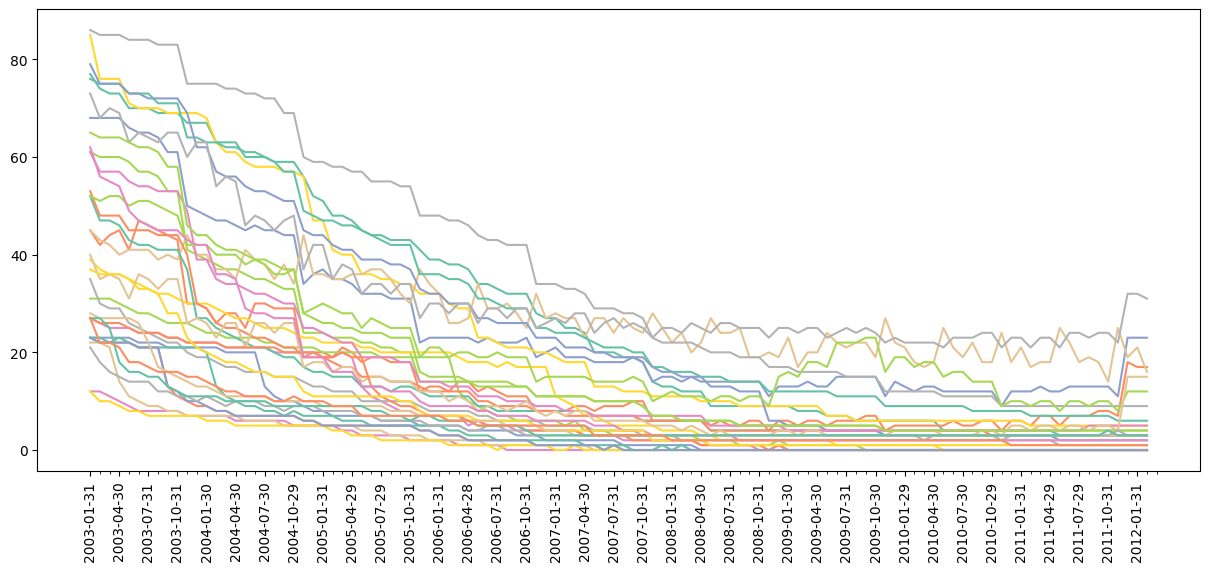

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(null)
plt.xticks(rotation=90, ha='center', labels=labels, ticks=range(0, len(df.index), 3))
plt.xticks(rotation=45, ha='right', labels=['']*len(df.index), ticks=range(len(df.index)), minor=True)

plt.show()

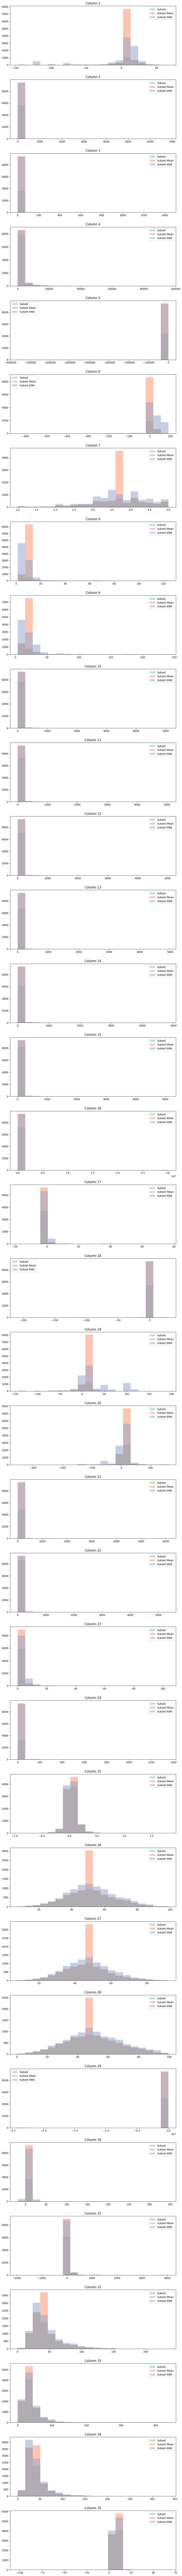

In [ ]:
num_columns = subset.shape[1]
fig, axs = plt.subplots(num_columns, figsize=(10, 4*num_columns))

# Plot the distribution of each array in each subplot
for i in range(num_columns):
    axs[i].hist(subset[:, i], alpha=0.5, label='Subset', bins=20)
    axs[i].hist(subset_mean[:, i], alpha=0.5, label='Subset Mean', bins=20)
    axs[i].hist(subset_knn[:, i], alpha=0.5, label='Subset KNN', bins=20)
    axs[i].set_title(f'Column {i+1}')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
df_no_null = pd.DataFrame(data=subset_no_null, index=subset.index, columns=subset.columns)

<Axes: ylabel='Frequency'>

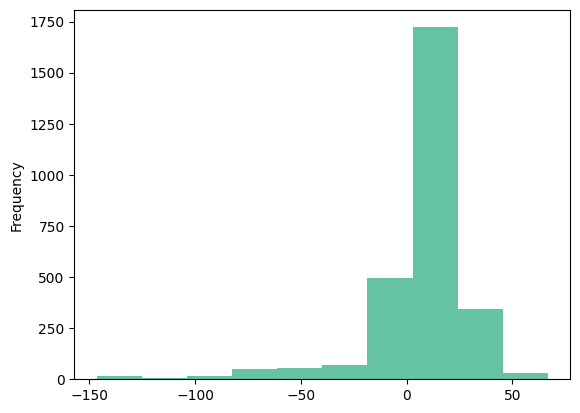

In [ ]:
subset['5YR_AVG_RETURN_ON_EQUITY'].plot(kind='hist')

<Axes: ylabel='Frequency'>

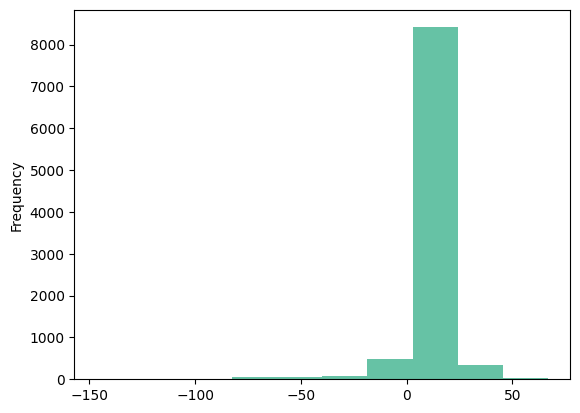

In [ ]:
df_no_null['5YR_AVG_RETURN_ON_EQUITY'].plot(kind='hist')

In [ ]:
ls_forest = {}
ts = df.index.to_list()
dt = 12                                # 1-year rolling window
for i in range(len(ts)-dt+1):
    df3 = data_stack.loc[ts[i]:ts[i+dt-1]]
    ls_forest[ts[i+dt-1]] = xs_forest(df3)    # add the model corresponding to i+dt-1, last period of rolling window
df_forest = pd.Series(ls_forest)

In [ ]:
res = {}

for t in df_forest.shift(1).index.to_list():
    df4 = data_stack.loc[t]
    df4 = df4[df4['RETURNS'].notna()]
    X_test, y_test = df4.drop(columns='RETURNS').values, df4['RETURNS'].values
    try:
        forest = df_forest.shift(1).loc[t]
        y_pred = forest.predict(X_test).reshape(-1)  # prediction array reshaped to 1d
    except:
        y_pred = np.nan
    res[t] = pd.DataFrame({'RETURNS': y_test, 'PREDICTIONS': y_pred}, index=df4.index)

res = pd.concat(res)
res.index.names = ['Date', 'ticker']

In [ ]:
df_ret = res.drop('2003-12-31', level=0, axis=0)['RETURNS']
df_pred = res.drop('2003-12-31', level=0, axis=0)['PREDICTIONS']
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(df_ret, df_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(df_ret, df_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(df_ret, df_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(df_ret, df_pred))
print('R^2:', metrics.r2_score(df_ret, df_pred))

## Prova

In [ ]:
cols = ['mom1m', 'mvel1', 'maxret', 'chmom', 'mom12m',
        'retvol', 'indmom', 'turn', 'nincr', 'dolvol',
        'sp', 'idiovol', 'mom6m', 'ill', 'std_turn',
        'securedind', 'ep', 'mom36m', 'zerotrade', 'baspread']
cols = ['exret'] + cols

data_pivot = data[cols].unstack().swaplevel(axis=1).sort_index(axis=1).reindex(cols, axis=1, level=1)

df_ols = data_pivot.loc['1975':].progress_apply(xs_ols, axis=1)
df_ols = pd.DataFrame(np.stack(df_ols.values), index=df_ols.index, columns=['const']+cols[1:]+['Adj. R2', 'No. Obs'])
df_ols

mean = df_ols.iloc[:, :-2].mean()                                   # mean value
se = df_ols.iloc[:, :-2].std() / df_ols.iloc[:, :-2].count()**0.5   # standard error
t = mean / se  # t-statistic
df_t = pd.concat([mean, se, t], axis=1)
df_t.columns = ['average', 'se', 't-statistic']
df_t['mark'] = df_t['t-statistic'].apply(lambda x: sig_mark(x))
df_t

df_prem = df_ols.rolling(12).mean().shift(1).loc['1976':].iloc[:, :-2]
data_stack = data_pivot.stack(level=0).loc['1976':, cols]
res = data_stack.exret.to_frame()
data_stack.columns = ['const'] + data_stack.columns.to_list()[1:]
data_stack.const = 1 # set a constant column

for t in df_prem.index:
    res.loc[t, 'pred'] = (data_stack.loc[t] * df_prem.loc[t]).sum(axis=1).values   # linear forecast


df_ret = res['exret'].unstack()
df_pred = res['pred'].unstack()
df_vol = df_ret.pipe(rollvol, 6).shift(1)   # use the 6-month rolling volatility to scale predicted returns
df_sig = df_pred.div(df_vol).applymap(lambda x: np.sign(x) if abs(x) > 0.7 else 0)  # set a threshold
df_bt_gkx = df_sig.mul(df_ret).sum(axis=1)      # create an equal-weighted trading signal
df_bt_gkx = df_bt_gkx.div(df_bt_gkx.pipe(rollvol, 12).shift(1)).mul(0.02)    # vol-scale the trading signal with a monthly 2%

df_bt_gkx = df_bt_gkx.to_frame('Gu-Kelly-Xiu')
df_bt_gkx['S&P 500 Index'] = sp500
df_bt_gkx.pipe(pq.plot_return, start='1990', period='monthly', title='Gu-Kelly-Xiu OLS Trading Signal')



from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

def xs_forest(df, n_estimators=4):
    '''Build a cross-sectional forest model and output the pipeline at each timestamp'''

    df = df[df['exret'].notna()] # sklearn does not have an imputing method unless specified
    X_train, y_train = df.iloc[:, 1:].values, df.iloc[:, 0].values  # do not leave out test sample in our training pipeline

    model = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'), RandomForestRegressor(n_estimators=n_estimators, random_state=42))
    model.fit(X_train, y_train)
    return model  # we return the model instead of slope estimations such that we can transform the next-period data later

ls_forest = {}
ts = data_stack.index.unique(level='Date').to_list()
dt = 12                                # 1-year rolling window
for i in range(len(ts)-dt+1):
    df = data_stack.loc[ts[i]:ts[i+dt-1]]
    ls_forest[ts[i+dt-1]] = xs_forest(df)    # add the model corresponding to i+dt-1, last period of rolling window
df_forest = pd.Series(ls_forest)

res = {}

for t in df_forest.shift(1).index.to_list():
    df = data_pivot.loc[t].unstack()
    df = df[df['exret'].notna()]
    X_test, y_test = df.iloc[:, 1:].values, df.iloc[:, 0].values
    try:
        forest = df_forest.shift(1).loc[t]
        y_pred = forest.predict(X_test).reshape(-1)  # prediction array reshaped to 1d
    except:
        y_pred = np.nan
    res[t] = pd.DataFrame({'exret': y_test, 'pred': y_pred}, index=df.index)

res = pd.concat(res)
res.index.names = ['Date', 'PERMNO']
res = res.loc['1976':]

df_ret = res['exret'].unstack()
df_pred = res['pred'].unstack()
df_vol = df_ret.pipe(rollvol, 6).shift(1)   # use the 6-month rolling volatility to scale predicted returns
df_sig = df_pred.div(df_vol).applymap(lambda x: np.sign(x) if abs(x) > 0.7 else 0)  # set a threshold
df_bt_forest = df_sig.mul(df_ret).sum(axis=1)      # create an equal-weighted trading signal
df_bt_forest = df_bt_forest.div(df_bt_forest.pipe(rollvol, 12).shift(1)).mul(0.02)    # vol-scale the trading signal with a monthly 2%

df_bt_forest = df_bt_forest.to_frame('Forest')
df_bt_forest['S&P 500 Index'] = sp500
df_bt_forest.pipe(pq.plot_return, start='1990', period='monthly', title='Fixed-Threshold Forest Trading Signal')